In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def generate_wave_data(num_samples = 10000, seq_len = 100):
    X,y = [],[]
    for _ in range(num_samples):
        freq = np.random.choice([1,5,10])
        phase = np.random.uniform(0,2*np.pi)
        t = np.linspace(0,1, seq_len)

        if np.random.rand() > 0.5:
            signal = np.sin(2*np.pi*freq*t + phase)
            label = 1
        else:
            signal = np.sign(np.sin(2*np.pi*freq*t + phase))
            label = 0

        # Add noise
        signal += np.random.normal(0,0.1, seq_len)

        X.append(signal)
        y.append(label)

    return np.array(X), np.array(y)


In [4]:
X,y = generate_wave_data()


In [5]:
X

array([[-1.12376172, -0.9457217 , -0.60803024, ..., -0.02262793,
        -0.67114361, -1.11695928],
       [-0.91371739, -0.94100533, -1.11278662, ..., -0.93559758,
        -0.99215515, -0.98989988],
       [-1.02039826, -0.96868277, -1.00033421, ...,  1.2306387 ,
        -0.95207375, -0.88226711],
       ...,
       [ 0.9550718 ,  0.88205076,  1.08684409, ..., -0.96859977,
        -0.95055814,  1.07996506],
       [-1.0985466 , -1.00504396, -1.0900903 , ..., -1.03226632,
        -1.23846921, -0.93976459],
       [-1.05477464, -0.95154938, -0.95658957, ...,  1.01386125,
        -1.06397722, -0.99255417]], shape=(10000, 100))

In [6]:
print(type(X))

<class 'numpy.ndarray'>


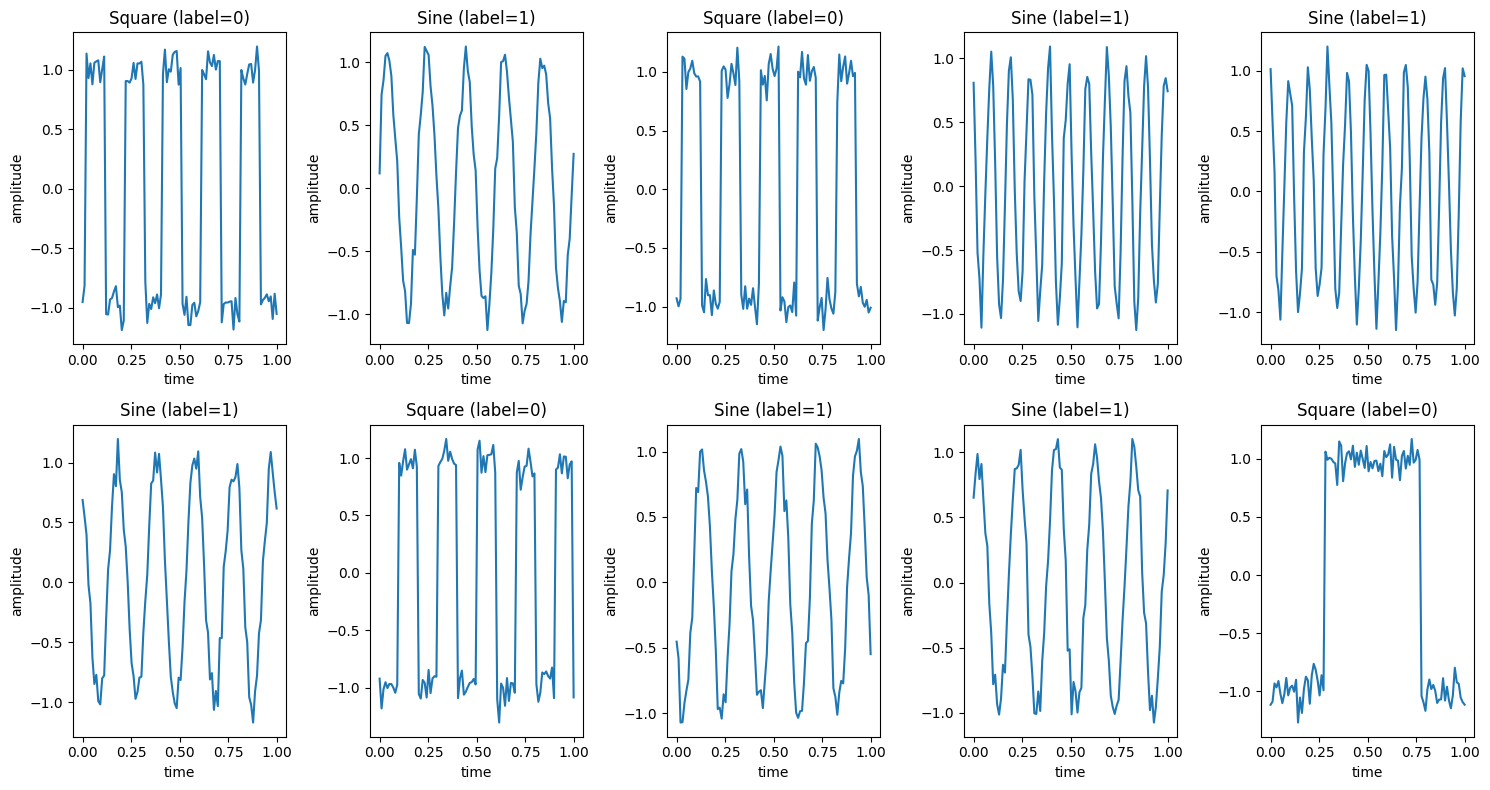

In [7]:
# Generate 10 examples
X, y = generate_wave_data(num_samples=10, seq_len=100)
t = np.linspace(0, 1, 100)

# Plot them
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)   # 2 rows, 5 columns
    plt.plot(t, X[i])
    plt.title(f"{'Sine' if y[i]==1 else 'Square'} (label={y[i]})")
    plt.xlabel("time")
    plt.ylabel("amplitude")
    plt.tight_layout()

plt.show()
def relu(x):
        return np.maximum(0, x)

In [8]:
## Forward pass just practice for understanding
X,y = generate_wave_data(num_samples=1)

# Take the single signal (since X has shape (1, seq_len))
signal = X[0]

# Make a kernel of length 4
kernel = np.random.rand(4)

feature_map = []

# Sliding window
for start in range(len(signal) - len(kernel) + 1):
    end = start + len(kernel)
    feature_val = 0

    # Compute dot product manually
    for i in range(len(kernel)):
        feature_val += signal[start + i] * kernel[i]

    feature_map.append(feature_val)

feature_map = np.array(feature_map)

## Now pass the feature map in ReLU, ReLU is something like np.maximum(0, x)
relu_feature_map = relu(feature_map)

## Let's do the max pooling in this value. Max pooling filter will have size 4.
max_pool = []
pool_size = 4
for i in range(0, len(relu_feature_map), pool_size):
    max_val = -1  # Initialized since ReLU can never be negative
    for j in range(i, i + pool_size):
        # Ensure the index j is within bounds of relu_feature_map
        if j < len(relu_feature_map):
            max_val = max(max_val, relu_feature_map[j])
        else:
            max_val = max(max_val, -1)  # Use -1 if j is out of bounds
    max_pool.append(max_val)

max_pool = np.array(max_pool)

print(max_pool)
        






[0.9726955  1.62781559 0.         1.4459944  0.71808913 0.89751733
 1.4654495  0.         1.50391263 0.62160235 0.96723751 1.4151874
 0.         1.42089004 0.224183   1.3038702  1.50262009 0.
 1.5258677  0.20327155 1.45250822 1.52113416 0.         1.43089582
 0.36501552]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


class WaveDetectorCNN:
    def __init__(self, batchSize=32, channel_input=1, lr=0.01,
                 filters=8, kernel_size=4, sequence_size=100,stride = 10, pool_size = 10, no_of_output_feature = 2):
        self.no_of_output_feature = no_of_output_feature
        self.B = batchSize
        self.C_in = channel_input
        self.F = filters
        self.K = kernel_size
        self.lr = lr
        self.stride = stride
        self.pool_size = pool_size
        self.L = sequence_size
        # Length after convolution
        L_conv = self.L - self.K + 1  

        # Length after pooling
        L_pool = (L_conv - self.pool_size) // self.stride + 1  

        # Weight initialization for dense layer
        self.W_dense = np.random.randn(self.F * L_pool, self.no_of_output_feature) * 0.1
        self.B_dense = np.zeros((self.no_of_output_feature,))


        # Save data if provided
        self.X = X
        self.y = y

        # Initialize kernel (filters)
        self.kernel = np.random.randn(self.F, self.C_in, self.K) * 0.1

        self.input = None

    
    def softmax(self, x):
        """
        x: (B, num_classes)
        Returns: probabilities for each class per sample
        """
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # stability trick
        probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return probs
    
    def compute_loss(self, probs, y_true):
        """
        probs: (B, num_classes)
        y_true: (B,)
        """
        B = y_true.shape[0]
        y_encoded = np.eye(self.no_of_output_feature)[y_true]
        log_likelihood = -np.log(probs[range(B), y_true] + 1e-9)
        loss = np.sum(log_likelihood) / B
        return loss

    
    def unpool(self, pooled_grad, binary_mask):
        """
        pooled_grad : (B, F, L_pooled)
        binary_mask : (B, F, L)
        Returns: unpooled gradient (B, F, L)
        """
        B, F, L = binary_mask.shape
        _, _, L_pooled = pooled_grad.shape
        unpooled = np.zeros_like(binary_mask, dtype=pooled_grad.dtype)

        for b in range(B):
            for f in range(F):
                for i in range(L_pooled):
                    start = i * self.stride
                    end = start + self.pool_size

                    # gradient for this region
                    grad = pooled_grad[b, f, i]

                    # distribute grad only to max positions
                    mask_window = binary_mask[b, f, start:end]
                    unpooled[b, f, start:end] += mask_window * grad

        return unpooled




    def generateFeatureMap(self,X=None):
        ''' 
        It will take two things:
        1. Kernal = (filters,Channel_input, kernal_size)
        2. Input = (Batch, Channel_input, sequence_size)
        
        It will give output : feature_maps: list of shape(batch, Filters, L_output)
        L_output = Sequence_length - kernal_size + 1

        '''

        if X is None:
            X = self.input  # Use stored input during training

        B, C_in, L = X.shape
        F,_,K = self.kernel.shape ## Not taken C_in in this case 'coz filter and input will always have the same number of channels.
        L_out = L - K + 1

        ## Initialize output feature map: (B,F,L_out)
        self.feature_maps = np.zeros((B,F,L_out))
        
        ##Start the sliding window loop
        for b in range(B):
            for f in range(F):
                feature = np.zeros(L_out)
                for c in range(C_in):
                    x = self.input[b,c] ## Shape (L,)
                    k = self.kernel[f,c] ## Shape (K,)

                    ## Applying sliding window convolution
                    for i in range(L_out):
                        window = x[i:i+K] ## Shape (K,)
                        feature[i] += np.sum(window * k) ## Merge all channels
                self.feature_maps[b,f] = feature
        return self.feature_maps
    
    def relu(self,x):
        return np.maximum(0, x)
    

    def generate_max_pooling(self, x):
        '''
        x : shape (B,F,L)
        Returns : Pooled output of shape (B,F,L_pooled)
        '''
        B,F,L = x.shape
        L_pool =  (L-self.pool_size)//self.stride + 1

        pooled = np.zeros((B,F,L_pool))
        self.binary_max_pool = np.zeros((B,F,L)) ## Since we need binary of the shape as feature map

        for b in range(B):
            for f in range(F):
                for i in range(L_pool):
                    start = i * self.stride
                    end = start + self.pool_size

                    ## Finding max value in window
                    window = x[b,f,start:end]
                    max_val = np.max(window)
                    pooled[b,f,i] = max_val

                    max_indices = np.where(window == max_val)[0]

                    for idx in max_indices:
                        self.binary_max_pool[b,f,start+idx] = 1

        return pooled
    
    def generate_flattened_array(self,x):
        '''
        x: [B,F,L_pooled]
        '''
        return x.reshape(self.B, -1)

    
    def feature_extraction(self):

        ## First I need to pass the kernel through X to get the feature map
        feature_map = self.generateFeatureMap()
        # print("Feature map:", feature_map.shape)

        ## Now next thing is to apply relu on the feature map
        self.relu_feature_map = self.relu(feature_map)

        ## Reduce the feature map
        self.max_pool = self.generate_max_pooling(self.relu_feature_map)
        # print("After pooling:", self.max_pool.shape)



        return self.max_pool
    
    
    
    def forward_decision_making(self,pooled_array):

        '''
        pooled_array = [B,F,L_pooled]
        '''
        B,F,L_pooled = pooled_array.shape
        ## Now flatten the array
        self.flattened_array = self.generate_flattened_array(pooled_array)
        # print("Flattened:", self.flattened_array.shape)


        ## Now we do densing, output will be 2 because we just have either sine or square wave
        # self.W_dense = np.random.randn(F*L_pooled,self.no_of_output_feature) * 0.1
        # self.B_dense = np.random.randn(self.no_of_output_feature,) * 0.1

        output = self.flattened_array @ self.W_dense + self.B_dense

        return output
    
    def forward(self):

        pooled_array = self.feature_extraction()
        final_decision = self.forward_decision_making(pooled_array=pooled_array)
        self.probabilities = self.softmax(final_decision)
        return self.probabilities
    
    def backprop_decision_making(self):
        ## y is in shape = (32,)
        # y_prob is in shape = (32,2), where each column is like one hot encoded form of whether there is 1 or 0.
        #  So just encode our y like that too.
        y_encoded = np.eye(self.no_of_output_feature)[self.y]

        ## Let's calculate loss wrt to logit(the output before taking softmax)
        dl_dz = self.probabilities - y_encoded # shape(B,output_nums)
        dl_dw = self.flattened_array.T @ dl_dz / self.B
        dl_db = np.mean(dl_dz,axis=0)

        ## Loss with flattened array to just propogate further
        dl_input = dl_dz @ self.W_dense.T # Shape(B,L_pooled*F)

        self.W_dense -= self.lr * dl_dw
        self.B_dense -= self.lr * dl_db

        return dl_input
    
    def backprop_convolution(self):
        dl_input = self.backprop_decision_making() ## (B,F*L_Pooled)

        ## We need to unflatten this before going to unpooling and then pass loss to kernel
        dl_input = dl_input.reshape(self.B, self.F, -1) ## (B,F,L_pooled)

        ## Need to unpool before relu
        dl_unpooled_input = self.unpool(dl_input, self.binary_max_pool) ## (B,F,L)


        ## Loss wrt to relu layer
        dl_drelu = dl_unpooled_input * (self.relu_feature_map > 0) ## (B,F,L)

        ## Now let's find the total loss for each kernal value
        dk = np.zeros_like(self.kernel) ## (F,C_in,K)
        B,C_in,L = self.input.shape
        F,_,K = self.kernel.shape
        L_out = L - K + 1

        for f in range(F):
            for c in range(C_in):
                for b in range(self.B):
                    x = self.input[b,c]
                    grad_output = dl_drelu[b,f]
                    for i in range(L_out):
                        window = x[i:i+K]
                        # multiply input window with output gradient and add
                        dk[f,c] += window * grad_output[i]

        ## Taking average of batch to remove the factor of big or small batch
        dk /= self.B

        ## Update kernal 
        self.kernel -= self.lr*dk


    def train(self, X, y, epochs=10):
        num_samples = X.shape[0]
        num_batches = num_samples // self.B

        for epoch in range(epochs):
            # Shuffle dataset each epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            total_loss = 0
            correct = 0

            for i in range(num_batches):
                # Get batch
                start = i * self.B
                end = start + self.B
                batch_X = X[start:end]
                batch_y = y[start:end]

                # Reshape input to (B, C_in, L)
                self.input = batch_X.reshape(self.B, self.C_in, self.L)
                self.y = batch_y

                # Forward + Backward
                probs = self.forward()
                self.backprop_convolution()

                # Compute loss and accuracy
                loss = self.compute_loss(probs, batch_y)
                total_loss += loss
                preds = np.argmax(probs, axis=1)
                correct += np.sum(preds == batch_y)

            avg_loss = total_loss / num_batches
            acc = correct / (num_batches * self.B)

            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Accuracy: {acc*100:.2f}%")


    # ----------------------------
    # PREDICT FUNCTION
    # ----------------------------
    def predict(self, X):
        """
        Takes X of shape (N, seq_len)
        Returns predicted labels
        """
        N = X.shape[0]
        preds = []

        # Loop through batches
        for i in range(0, N, self.B):
            batch_X = X[i:i+self.B]
            batch_size = batch_X.shape[0]
            batch_X = np.reshape(batch_X, (batch_size, self.C_in, self.L))

            # Forward pass
            feature_map = self.generateFeatureMap(batch_X)
            relu_feature = self.relu(feature_map)
            pooled = self.generate_max_pooling(relu_feature)
            flat = pooled.reshape(batch_size, -1)

            z = np.dot(flat, self.W_dense) + self.B_dense
            probs = self.softmax(z)
            preds_batch = np.argmax(probs, axis=1)

            preds.extend(preds_batch)

        return np.array(preds)
    
    # ----------------------------
    # EVALUATE FUNCTION
    # ----------------------------
    def evaluate(self, X_test, y_test):
        preds = self.predict(X_test)
        acc = accuracy_score(y_test, preds)
        cm = confusion_matrix(y_test, preds)
        report = classification_report(y_test, preds, digits=4)

        print(f"Accuracy: {acc*100:.2f}%")
        print("\nConfusion Matrix:\n", cm)
        print("\nClassification Report:\n", report)




        

        


    










In [18]:
from sklearn.model_selection import train_test_split

# Generate data
X, y = generate_wave_data(num_samples=10000, seq_len=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
model = WaveDetectorCNN(batchSize=32, sequence_size=100)

# Train model
model.train(X_train, y_train, epochs=10)

# Evaluate model
model.evaluate(X_test, y_test)


Epoch [1/10] - Loss: 0.6173 - Accuracy: 59.30%
Epoch [2/10] - Loss: 0.5031 - Accuracy: 82.33%
Epoch [3/10] - Loss: 0.3917 - Accuracy: 91.05%
Epoch [4/10] - Loss: 0.3057 - Accuracy: 91.72%
Epoch [5/10] - Loss: 0.2522 - Accuracy: 93.95%
Epoch [6/10] - Loss: 0.2185 - Accuracy: 95.26%
Epoch [7/10] - Loss: 0.1954 - Accuracy: 96.53%
Epoch [8/10] - Loss: 0.1782 - Accuracy: 97.29%
Epoch [9/10] - Loss: 0.1641 - Accuracy: 98.34%
Epoch [10/10] - Loss: 0.1525 - Accuracy: 98.52%
Accuracy: 50.55%

Confusion Matrix:
 [[547 474]
 [515 464]]

Classification Report:
               precision    recall  f1-score   support

           0     0.5151    0.5357    0.5252      1021
           1     0.4947    0.4740    0.4841       979

    accuracy                         0.5055      2000
   macro avg     0.5049    0.5049    0.5046      2000
weighted avg     0.5051    0.5055    0.5051      2000

